# Getting even faster by reducing allocations and by multi-threading

* Gen Kuroki
* 2021-06-28

In [1]:
VERSION

v"1.6.1"

## Original version

* https://twitter.com/elbersb/status/1409454534666207232
* https://elbersb.com/public/posts/interaction_simulation/

In [2]:
using Distributions 
using DataFrames     

const std_normal = Normal(0, 1)

function gen_data()
    ## total time periods in the the panel = 500
    tt = 500

    # x1 and x2 covariates
    x1_A = 1 .+ rand(std_normal, tt)
    x1_B = 1/4 .+ rand(std_normal, tt)
    x2_A = 1 .+ x1_A .+ rand(std_normal, tt)
    x2_B = 1 .+ x1_B .+ rand(std_normal, tt)

    # outcomes (notice different slope coefs for x2_A and x2_B)
    y_A = x1_A .+ 1*x2_A + rand(std_normal, tt)
    y_B = x1_B .+ 2*x2_B + rand(std_normal, tt)

    # combine
    DataFrame(
        id = vcat(fill(0, length(x1_A)), fill(1, length(x1_B))),
        x1 = vcat(x1_A, x1_B),
        x2 = vcat(x2_A, x2_B),
        x1_dmean = vcat(x1_A .- mean(x1_A), x1_B .- mean(x1_B)),
        x2_dmean = vcat(x2_A .- mean(x2_A), x2_B .- mean(x2_B)),
        y = vcat(y_A, y_B))
end

gen_data (generic function with 1 method)

In [3]:
using GLM

function coefs_lm_formula(data)
    mod_level = lm(@formula(y ~ id + x1 * x2), data)
    mod_dmean = lm(@formula(y ~ id + x1_dmean * x2_dmean), data)
    (coef(mod_level)[end], coef(mod_dmean)[end])
end

# example
data = gen_data()
coefs_lm_formula(data)

(-0.14620466773983154, -0.026738115648363484)

In [4]:
function run_simulations(nsim)
    sims = zeros(nsim, 2);
    for i in 1:nsim
        data = gen_data()
        sims[i, :] .= coefs_lm_formula(data)
    end
    sims
end

using BenchmarkTools
n = 20000
@btime run_simulations($n);

  8.495 s (23260002 allocations: 16.87 GiB)


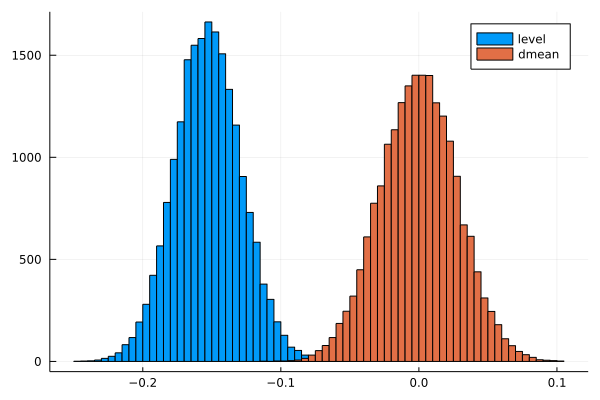

In [5]:
using Plots
sims = run_simulations(n)
histogram(sims, label = ["level" "dmean"])

In [6]:
function coefs_lm_formula(data)
    constant = fill(1, nrow(data))
    X = Float64[constant data.id data.x1 data.x2 data.x1 .* data.x2]
    mod_level = fit(LinearModel, X, data.y)
    X[:, 5] .= data.x1_dmean .* data.x2_dmean
    mod_dmean = fit(LinearModel, X, data.y)
    (coef(mod_level)[end], coef(mod_dmean)[end])
end

@btime run_simulations($n);

  3.372 s (2800002 allocations: 8.30 GiB)


In [7]:
using LinearAlgebra 
fastfit(X, y) = cholesky!(Symmetric(X' * X)) \ (X' * y)

function coefs_lm_formula(data)
    constant = fill(1, nrow(data))
    X = Float64[constant data.id data.x1 data.x2 data.x1 .* data.x2]
    mod_level = fastfit(X, data.y)
    X[:, 5] .= data.x1_dmean .* data.x2_dmean
    mod_dmean = fastfit(X, data.y)
    (mod_level[end], mod_dmean[end])
end

@btime run_simulations($n);

  2.191 s (2040002 allocations: 4.65 GiB)


## Optimized version: Reducing allocations

Ref. [Performance Tips: Pre-allocating outputs](https://docs.julialang.org/en/v1/manual/performance-tips/#Pre-allocating-outputs)

n = 20000 = 20000
  1.841701 seconds (4.02 M allocations: 212.852 MiB, 2.88% gc time, 45.74% compilation time)


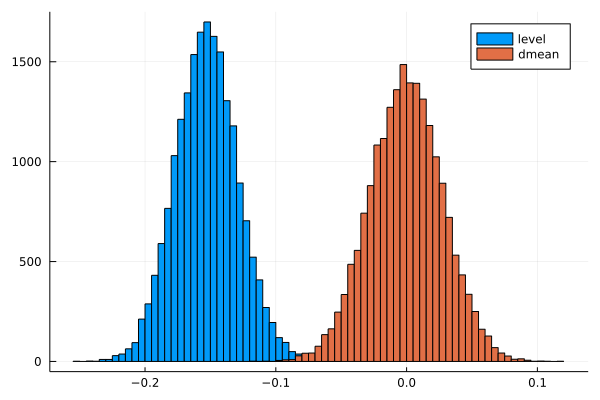

In [8]:
using DataFrames
using Distributions
using LinearAlgebra
using Random: rand!
using BenchmarkTools
using Plots

const std_normal = Normal(0, 1)

function undef_data(tt)
    id = vcat(fill(0, tt), fill(1, tt))
    x1 = similar(id, Float64)
    x2 = similar(x1)
    x1_dmean = similar(x1)
    x2_dmean = similar(x2)
    y = similar(x1)
    DataFrame(id = id, x1 = x1, x2 = x2, x1_dmean = x1_dmean, x2_dmean = x2_dmean, y = y)
end

function gen_data!(data, tmp)
    tt = length(tmp) # Assume 2tt = nrow(data)
    A, B = 1:tt, tt+1:2tt
    
    # Warning: dataframe is type-unstable
    x1::Vector{Float64} = data.x1
    x2::Vector{Float64} = data.x2
    x1_dmean::Vector{Float64} = data.x1_dmean
    x2_dmean::Vector{Float64} = data.x2_dmean
    y::Vector{Float64} = data.y
    
    @views x1[A] .= 1   .+ rand!(std_normal, tmp)
    @views x1[B] .= 1/4 .+ rand!(std_normal, tmp)
    @views x2[A] .= 1   .+ x1[A] .+ rand!(std_normal, tmp)
    @views x2[B] .= 1   .+ x1[B] .+ rand!(std_normal, tmp)

    # outcomes (notice different slope coefs for x2[A] and x2[B])
    @views y[A] .= x1[A] .+ 1 .* x2[A] .+ rand!(std_normal, tmp)
    @views y[B] .= x1[B] .+ 2 .* x2[B] .+ rand!(std_normal, tmp)
    
    @views x1_dmean[A] .= x1[A] .- mean(x1[A])
    @views x1_dmean[B] .= x1[B] .- mean(x1[B])
    @views x2_dmean[A] .= x2[A] .- mean(x2[A])
    @views x2_dmean[B] .= x2[B] .- mean(x2[B])
    
    data
end

function fastfit!(mod, X, y, XtX, Xty)
    mul!(XtX, X', X)
    mul!(Xty, X', y)
    ldiv!(mod, cholesky!(Symmetric(XtX)), Xty)
end

function coefs_lm_formula!(result, data, X, mod_level, mod_dmean, XtX, Xty)
    # Warning: dataframe is type-unstable.
    id::Vector{Int} = data.id
    x1::Vector{Float64} = data.x1
    x2::Vector{Float64} = data.x2
    x1_dmean::Vector{Float64} = data.x1_dmean
    x2_dmean::Vector{Float64} = data.x2_dmean
    y::Vector{Float64} = data.y
    
    X[:, 1] .= 1
    X[:, 2] .= id
    X[:, 3] .= x1
    X[:, 4] .= x2
    X[:, 5] .= x1 .* x2
    fastfit!(mod_level, X, y, XtX, Xty)

    X[:, 5] .= x1_dmean .* x2_dmean
    fastfit!(mod_dmean, X, y, XtX, Xty)
    
    result .= (mod_level[end], mod_dmean[end])
end

function run_simulations_optimized(nsim, tt=500)
    sims = Matrix{Float64}(undef, nsim, 2)
    data = undef_data(tt)
    tmp = Vector{Float64}(undef, tt)
    X = Matrix{Float64}(undef, 2tt, 5)
    mod_level = Vector{Float64}(undef, 5)
    mod_dmean = similar(mod_level)
    XtX = Matrix{Float64}(undef, 5, 5)
    Xty = Vector{Float64}(undef, 5)
    for i in 1:nsim
        gen_data!(data, tmp)
        @views coefs_lm_formula!(sims[i, :], data, X, mod_level, mod_dmean, XtX, Xty)
    end
    sims
end

@show n = 20000
@time sims = run_simulations_optimized(n)
histogram(sims, label = ["level" "dmean"])

In [9]:
tt = 500
data = undef_data(tt)
tmp = Vector{Float64}(undef, tt)
X = Matrix{Float64}(undef, 2tt, 5)
mod_level = Vector{Float64}(undef, 5)
mod_dmean = similar(mod_level)
XtX = Matrix{Float64}(undef, 5, 5)
Xty = Vector{Float64}(undef, 5)
sim = zeros(2)
n = 20000

println("Optimized version:")
@btime gen_data!($data, $tmp)
@btime coefs_lm_formula!($sim, $data, $X, $mod_level, $mod_dmean, $XtX, $Xty)
@btime run_simulations_optimized($n);

Optimized version:
  27.100 μs (0 allocations: 0 bytes)
  14.700 μs (8 allocations: 288 bytes)
  907.061 ms (160062 allocations: 5.94 MiB)


In [10]:
println("Original version:")
@btime gen_data()
@btime coefs_lm_formula($data)
@btime run_simulations($n);

Original version:
  41.000 μs (73 allocations: 187.31 KiB)
  21.100 μs (26 allocations: 56.52 KiB)
  2.252 s (2040002 allocations: 4.65 GiB)


## Multi-thread original version

Threads.nthreads() = 12
  1.802908 seconds (2.14 M allocations: 4.659 GiB, 40.37% gc time, 1.47% compilation time)


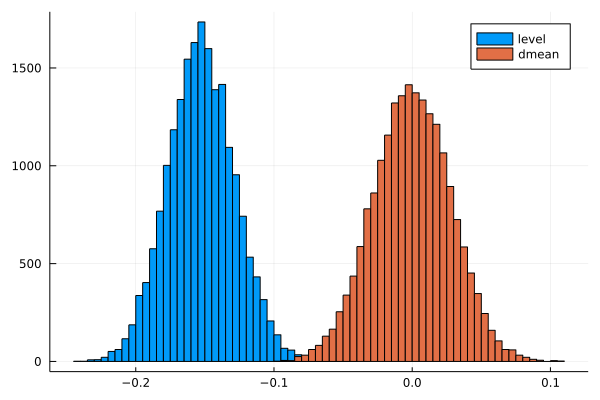

In [11]:
function run_simulations_multithread(nsim)
    sims = zeros(nsim, 2);
    Threads.@threads for i in 1:nsim
        data = gen_data()
        sims[i, :] .= coefs_lm_formula(data)
    end
    sims
end

@show Threads.nthreads()
@time sims = run_simulations_multithread(n)
histogram(sims, label = ["level" "dmean"])

In [12]:
println("Multi-thread original version: ")
@show Threads.nthreads()
@btime run_simulations_multithread($n);

Multi-thread original version: 
Threads.nthreads() = 12
  1.527 s (2040068 allocations: 4.65 GiB)


## Multi-thread optimized version

Threads.nthreads() = 12
  0.204476 seconds (229.28 k allocations: 11.634 MiB, 5.18% compilation time)


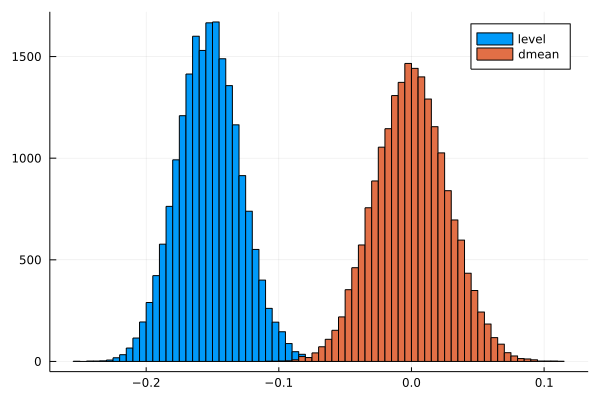

In [13]:
# pkg> dev https://github.com/genkuroki/MyUtils.jl
using MyUtils: @my_threads

function run_simulations_multithread_optimized(nsim, tt=500)
    sims = Matrix{Float64}(undef, nsim, 2)
    @my_threads begin
        data = undef_data(tt)
        tmp = Vector{Float64}(undef, tt)
        X = Matrix{Float64}(undef, 2tt, 5)
        mod_level = Vector{Float64}(undef, 5)
        mod_dmean = similar(mod_level)
        XtX = Matrix{Float64}(undef, 5, 5)
        Xty = Vector{Float64}(undef, 5)
    end for i in 1:nsim
        gen_data!(data, tmp)
        @views coefs_lm_formula!(sims[i, :], data, X, mod_level, mod_dmean, XtX, Xty)
    end begin
    end
    sims
end

@show Threads.nthreads()
@time sims = run_simulations_multithread_optimized(n)
histogram(sims, label = ["level" "dmean"])

In [14]:
println("Multi-thread optimized version: ")
@show Threads.nthreads()
@btime run_simulations_multithread_optimized($n);

Multi-thread optimized version: 
Threads.nthreads() = 12
  169.589 ms (160786 allocations: 7.56 MiB)


## non-DataFrame version

https://discourse.julialang.org/t/simulation-of-regression-coefficients/63683/2

In [15]:
using Distributions
using LinearAlgebra
using BenchmarkTools
using Plots
using Base.Threads

const std_normal = Normal(0, 1)
fastfit(X, y) = cholesky!(Symmetric(X' * X)) \ (X' * y)

function gen_data2!(X, y, x1_dmean, x2_dmean)
    ## total time periods in the the panel = 500
    tt = 500

    # x1 and x2 covariates
    x1_A = 1 .+ rand(std_normal, tt)
    x1_B = 1/4 .+ rand(std_normal, tt)
    x2_A = 1 .+ x1_A .+ rand(std_normal, tt)
    x2_B = 1 .+ x1_B .+ rand(std_normal, tt)

    # outcomes (notice different slope coefs for x2_A and x2_B)
    y_A = x1_A .+ 1*x2_A + rand(std_normal, tt)
    y_B = x1_B .+ 2*x2_B + rand(std_normal, tt)
    x1 = vcat(x1_A, x1_B)
    x2 = vcat(x2_A, x2_B)

    X[:, 2] .= vcat(fill(0, length(x1_A)), fill(1, length(x1_B)))
    X[:, 3] .= x1
    X[:, 4] .= x2
    X[:, 5] .= (x1 .* x2)

    y .= vcat(y_A, y_B)

    x1_dmean .= vcat(x1_A .- mean(x1_A), x1_B .- mean(x1_B))
    x2_dmean .= vcat(x2_A .- mean(x2_A), x2_B .- mean(x2_B))
end

function coefs_lm_formula4(X, y, x1_dmean, x2_dmean)
    mod_level = fastfit(X, y)
    @inbounds X[:, 5] .= x1_dmean .* x2_dmean
    mod_dmean = fastfit(X, y)
    (mod_level[end], mod_dmean[end])
end

function run_simulations5(nsim)
    sims = zeros(nsim, 2);
    X = [zeros(Float64, 1000, 5) for _ in 1:nthreads()]
    y = [zeros(Float64, 1000) for _ in 1:nthreads()]
    x1_dmean = [zeros(Float64, 1000) for _ in 1:nthreads()]
    x2_dmean = [zeros(Float64, 1000) for _ in 1:nthreads()]

    # set constant
    for i in 1:nthreads()
        X[i][:, 1] .= 1
    end

    @threads for i in 1:nsim
        gen_data2!(X[threadid()], y[threadid()], x1_dmean[threadid()], x2_dmean[threadid()])
        @inbounds sims[i, 1], sims[i, 2] = coefs_lm_formula4(X[threadid()], y[threadid()], x1_dmean[threadid()], x2_dmean[threadid()])
    end
    sims
end

run_simulations5 (generic function with 1 method)

Threads.nthreads() = 12
  1.447246 seconds (2.48 M allocations: 2.726 GiB, 24.63% gc time, 10.16% compilation time)


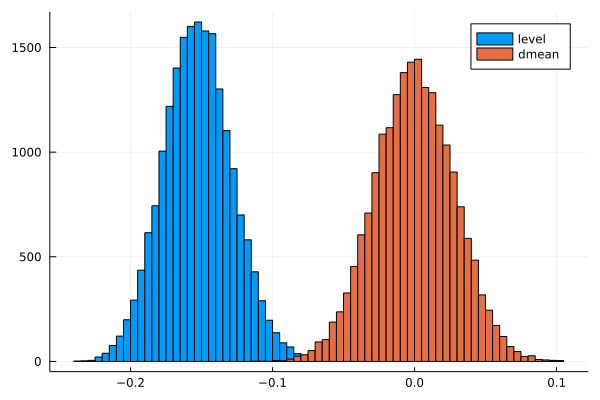

In [16]:
n = 20000
@show Threads.nthreads()
@time sims = run_simulations5(n)
histogram(sims, label = ["level" "dmean"])

In [17]:
println("Multi-thread non-dataframe version (run_simulations5): ")
@show Threads.nthreads()
@btime run_simulations5($n);

Multi-thread non-dataframe version (run_simulations5): 
Threads.nthreads() = 12
  664.780 ms (760131 allocations: 2.64 GiB)


## Optimized non-DataFrame version

n = 20000 = 20000
  1.514930 seconds (2.50 M allocations: 128.396 MiB, 3.07% gc time, 35.76% compilation time)


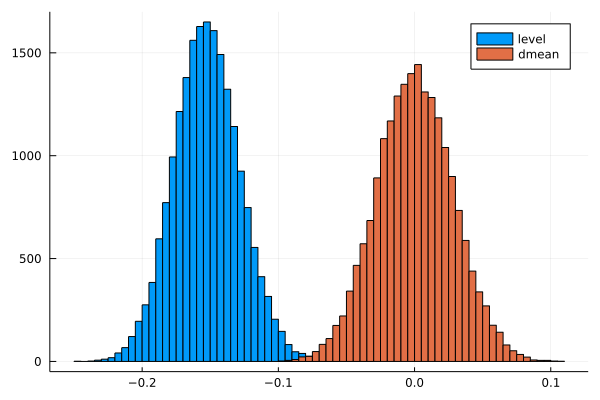

In [18]:
using Distributions
using LinearAlgebra
using Random: rand!
using BenchmarkTools
using Plots

const std_normal = Normal(0, 1)

# use NamedTuple indtead of DataFrame
function undef_data_namedtuple(tt)
    id = vcat(fill(0, tt), fill(1, tt))
    x1 = similar(id, Float64)
    x2 = similar(x1)
    x1_dmean = similar(x1)
    x2_dmean = similar(x2)
    y = similar(x1)
    (; id, x1, x2, x1_dmean, x2_dmean, y)
end

function gen_data!(data, tmp)
    tt = length(tmp) # Assume 2tt = nrow(data)
    A, B = 1:tt, tt+1:2tt
    
    # Warning: dataframe is type-unstable
    x1::Vector{Float64} = data.x1
    x2::Vector{Float64} = data.x2
    x1_dmean::Vector{Float64} = data.x1_dmean
    x2_dmean::Vector{Float64} = data.x2_dmean
    y::Vector{Float64} = data.y
    
    @views x1[A] .= 1   .+ rand!(std_normal, tmp)
    @views x1[B] .= 1/4 .+ rand!(std_normal, tmp)
    @views x2[A] .= 1   .+ x1[A] .+ rand!(std_normal, tmp)
    @views x2[B] .= 1   .+ x1[B] .+ rand!(std_normal, tmp)

    # outcomes (notice different slope coefs for x2[A] and x2[B])
    @views y[A] .= x1[A] .+ 1 .* x2[A] .+ rand!(std_normal, tmp)
    @views y[B] .= x1[B] .+ 2 .* x2[B] .+ rand!(std_normal, tmp)
    
    @views x1_dmean[A] .= x1[A] .- mean(x1[A])
    @views x1_dmean[B] .= x1[B] .- mean(x1[B])
    @views x2_dmean[A] .= x2[A] .- mean(x2[A])
    @views x2_dmean[B] .= x2[B] .- mean(x2[B])
    
    data
end

function fastfit!(mod, X, y, XtX, Xty)
    mul!(XtX, X', X)
    mul!(Xty, X', y)
    ldiv!(mod, cholesky!(Symmetric(XtX)), Xty)
end

function coefs_lm_formula!(result, data, X, mod_level, mod_dmean, XtX, Xty)
    # Warning: dataframe is type-unstable.
    id::Vector{Int} = data.id
    x1::Vector{Float64} = data.x1
    x2::Vector{Float64} = data.x2
    x1_dmean::Vector{Float64} = data.x1_dmean
    x2_dmean::Vector{Float64} = data.x2_dmean
    y::Vector{Float64} = data.y
    
    X[:, 1] .= 1
    X[:, 2] .= id
    X[:, 3] .= x1
    X[:, 4] .= x2
    X[:, 5] .= x1 .* x2
    fastfit!(mod_level, X, y, XtX, Xty)

    X[:, 5] .= x1_dmean .* x2_dmean
    fastfit!(mod_dmean, X, y, XtX, Xty)
    
    result .= (mod_level[end], mod_dmean[end])
end

function run_simulations_optimized_nondataframe(nsim, tt=500)
    sims = Matrix{Float64}(undef, nsim, 2)
    data = undef_data_namedtuple(tt) # use NamedTuple indtead of DataFrame
    tmp = Vector{Float64}(undef, tt)
    X = Matrix{Float64}(undef, 2tt, 5)
    mod_level = Vector{Float64}(undef, 5)
    mod_dmean = similar(mod_level)
    XtX = Matrix{Float64}(undef, 5, 5)
    Xty = Vector{Float64}(undef, 5)
    for i in 1:nsim
        gen_data!(data, tmp)
        @views coefs_lm_formula!(sims[i, :], data, X, mod_level, mod_dmean, XtX, Xty)
    end
    sims
end

@show n = 20000
@time sims = run_simulations_optimized_nondataframe(n)
histogram(sims, label = ["level" "dmean"])

In [19]:
println("Optimized non-dataframe version (single thread): ")
@btime run_simulations_optimized_nondataframe($n);

Optimized non-dataframe version (single thread): 
  885.032 ms (160017 allocations: 5.90 MiB)


## Multi-thread optimized non-DataFrame version

Threads.nthreads() = 12
  0.211943 seconds (228.71 k allocations: 11.044 MiB, 6.34% compilation time)


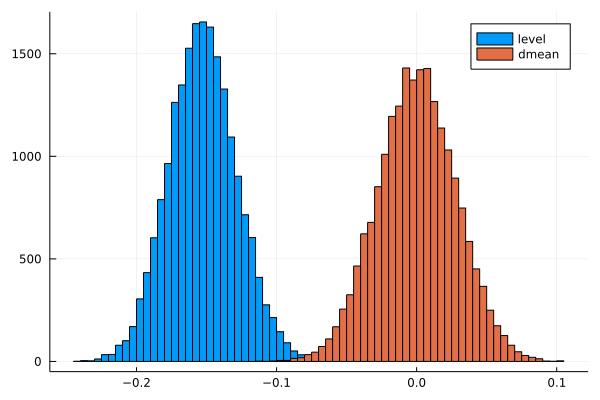

In [20]:
# pkg> dev https://github.com/genkuroki/MyUtils.jl
using MyUtils: @my_threads

function run_simulations_multithread_optimized_nondataframe(nsim, tt=500)
    sims = Matrix{Float64}(undef, nsim, 2)
    @my_threads begin
        data = undef_data_namedtuple(tt)
        tmp = Vector{Float64}(undef, tt)
        X = Matrix{Float64}(undef, 2tt, 5)
        mod_level = Vector{Float64}(undef, 5)
        mod_dmean = similar(mod_level)
        XtX = Matrix{Float64}(undef, 5, 5)
        Xty = Vector{Float64}(undef, 5)
    end for i in 1:nsim
        gen_data!(data, tmp)
        @views coefs_lm_formula!(sims[i, :], data, X, mod_level, mod_dmean, XtX, Xty)
    end begin
    end
    sims
end

@show Threads.nthreads()
@time sims = run_simulations_multithread_optimized_nondataframe(n)
histogram(sims, label = ["level" "dmean"])

In [21]:
println("Multi-thread optimized non-dataframe version: ")
@show Threads.nthreads()
@btime run_simulations_multithread_optimized_nondataframe($n);

Multi-thread optimized non-dataframe version: 
Threads.nthreads() = 12
  163.337 ms (160247 allocations: 6.97 MiB)


## Summary

In [22]:
n = 20000

@show VERSION
@show n
@show Threads.nthreads()
println()

println("Original version (with DataFrame, single thread):")
@btime run_simulations($n)
println()

println("Optimized version (with DataFrame, single thread):")
@btime run_simulations_optimized($n)
println()

println("Multi-thread optimized version (with DataFrame): ")
@show Threads.nthreads()
@btime run_simulations_multithread_optimized($n)
println()

println("Multi-thread non-dataframe version (run_simulations5): ")
@btime run_simulations5($n)
println()

println("Optimized non-dataframe version (single thread): ")
@btime run_simulations_optimized_nondataframe($n)
println()

println("Multi-thread optimized non-dataframe version: ")
@btime run_simulations_multithread_optimized_nondataframe($n)
println()

VERSION = v"1.6.1"
n = 20000
Threads.nthreads() = 12

Original version (with DataFrame, single thread):
  1.844 s (2040002 allocations: 4.65 GiB)

Optimized version (with DataFrame, single thread):
  916.280 ms (160062 allocations: 5.94 MiB)

Multi-thread optimized version (with DataFrame): 
Threads.nthreads() = 12
  169.918 ms (160786 allocations: 7.56 MiB)

Multi-thread non-dataframe version (run_simulations5): 
  694.743 ms (760130 allocations: 2.64 GiB)

Optimized non-dataframe version (single thread): 
  886.152 ms (160017 allocations: 5.90 MiB)

Multi-thread optimized non-dataframe version: 
  162.572 ms (160246 allocations: 6.97 MiB)



In [23]:
versioninfo()

Julia Version 1.6.1
Commit 6aaedecc44 (2021-04-23 05:59 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)
Environment:
  JULIA_DEPOT_PATH = D:\.julia
  JULIA_NUM_THREADS = 12
  JULIA_PYTHONCALL_EXE = D:\.julia\conda\3\python.exe
